In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import statistics as sts
from lmfit import Model
from scipy.stats import sem

In [ ]:
# Questions
# save = input('Save?')
# f = input('Include linear fit?')

# Variables for names and files
split = 'LSB_07'
metals = {'0G_13': 'Pt',
          '0G_14' : 'Al',
          '0G_15' : 'Mo',
          '0G_16' : 'Cr',
        }

# Linear Fit
def line(x, m, b):
    return x * m + b
gmodel = Model(line)
param = gmodel.make_params()

# Folder where the files are
data_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'LCR')
dict = {}
r_dict = {}
row_names = []
for i in os.listdir(data_path):
    files = os.listdir(os.path.join(data_path, i))
    for j in files:
        row_names.append(i + ' ' + j[:-4])
        data = pd.read_csv(os.path.join(data_path, i, j))
        dict[i] = (data['DC'], data['Idc'], data['Vds'])
        fig, ax = plt.subplots(dpi = 400, facecolor = 'white')
        ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
        ax.set_xlabel('Potential Vds (V)')
        ax.set_ylabel('Current Ids (A)')
        ax.scatter(dict[i][2], dict[i][1], s = 1)

        result = gmodel.fit(dict[i][1], param, m = 1, b = 1, x = dict[i][2])
        resistance = np.round(1 / result.values['m'], decimals = 2)
        r_square = 1 - result.residual.var() / np.var(dict[i][1])
        r_dict[metals[i] + ' ' + j[:-4]] = (float(resistance))

        ax.plot(dict[i][2], result.best_fit, alpha = 0.5, label = 'Linear Fit')
        ax.plot([],[], ' ', label = '{:.2f}'.format(resistance) + ' $\Omega$')
        ax.plot([],[], ' ', label = 'r$^2$ = ' + '{:.5f}'.format(r_square))
        
        ax.legend(markerscale = 5)

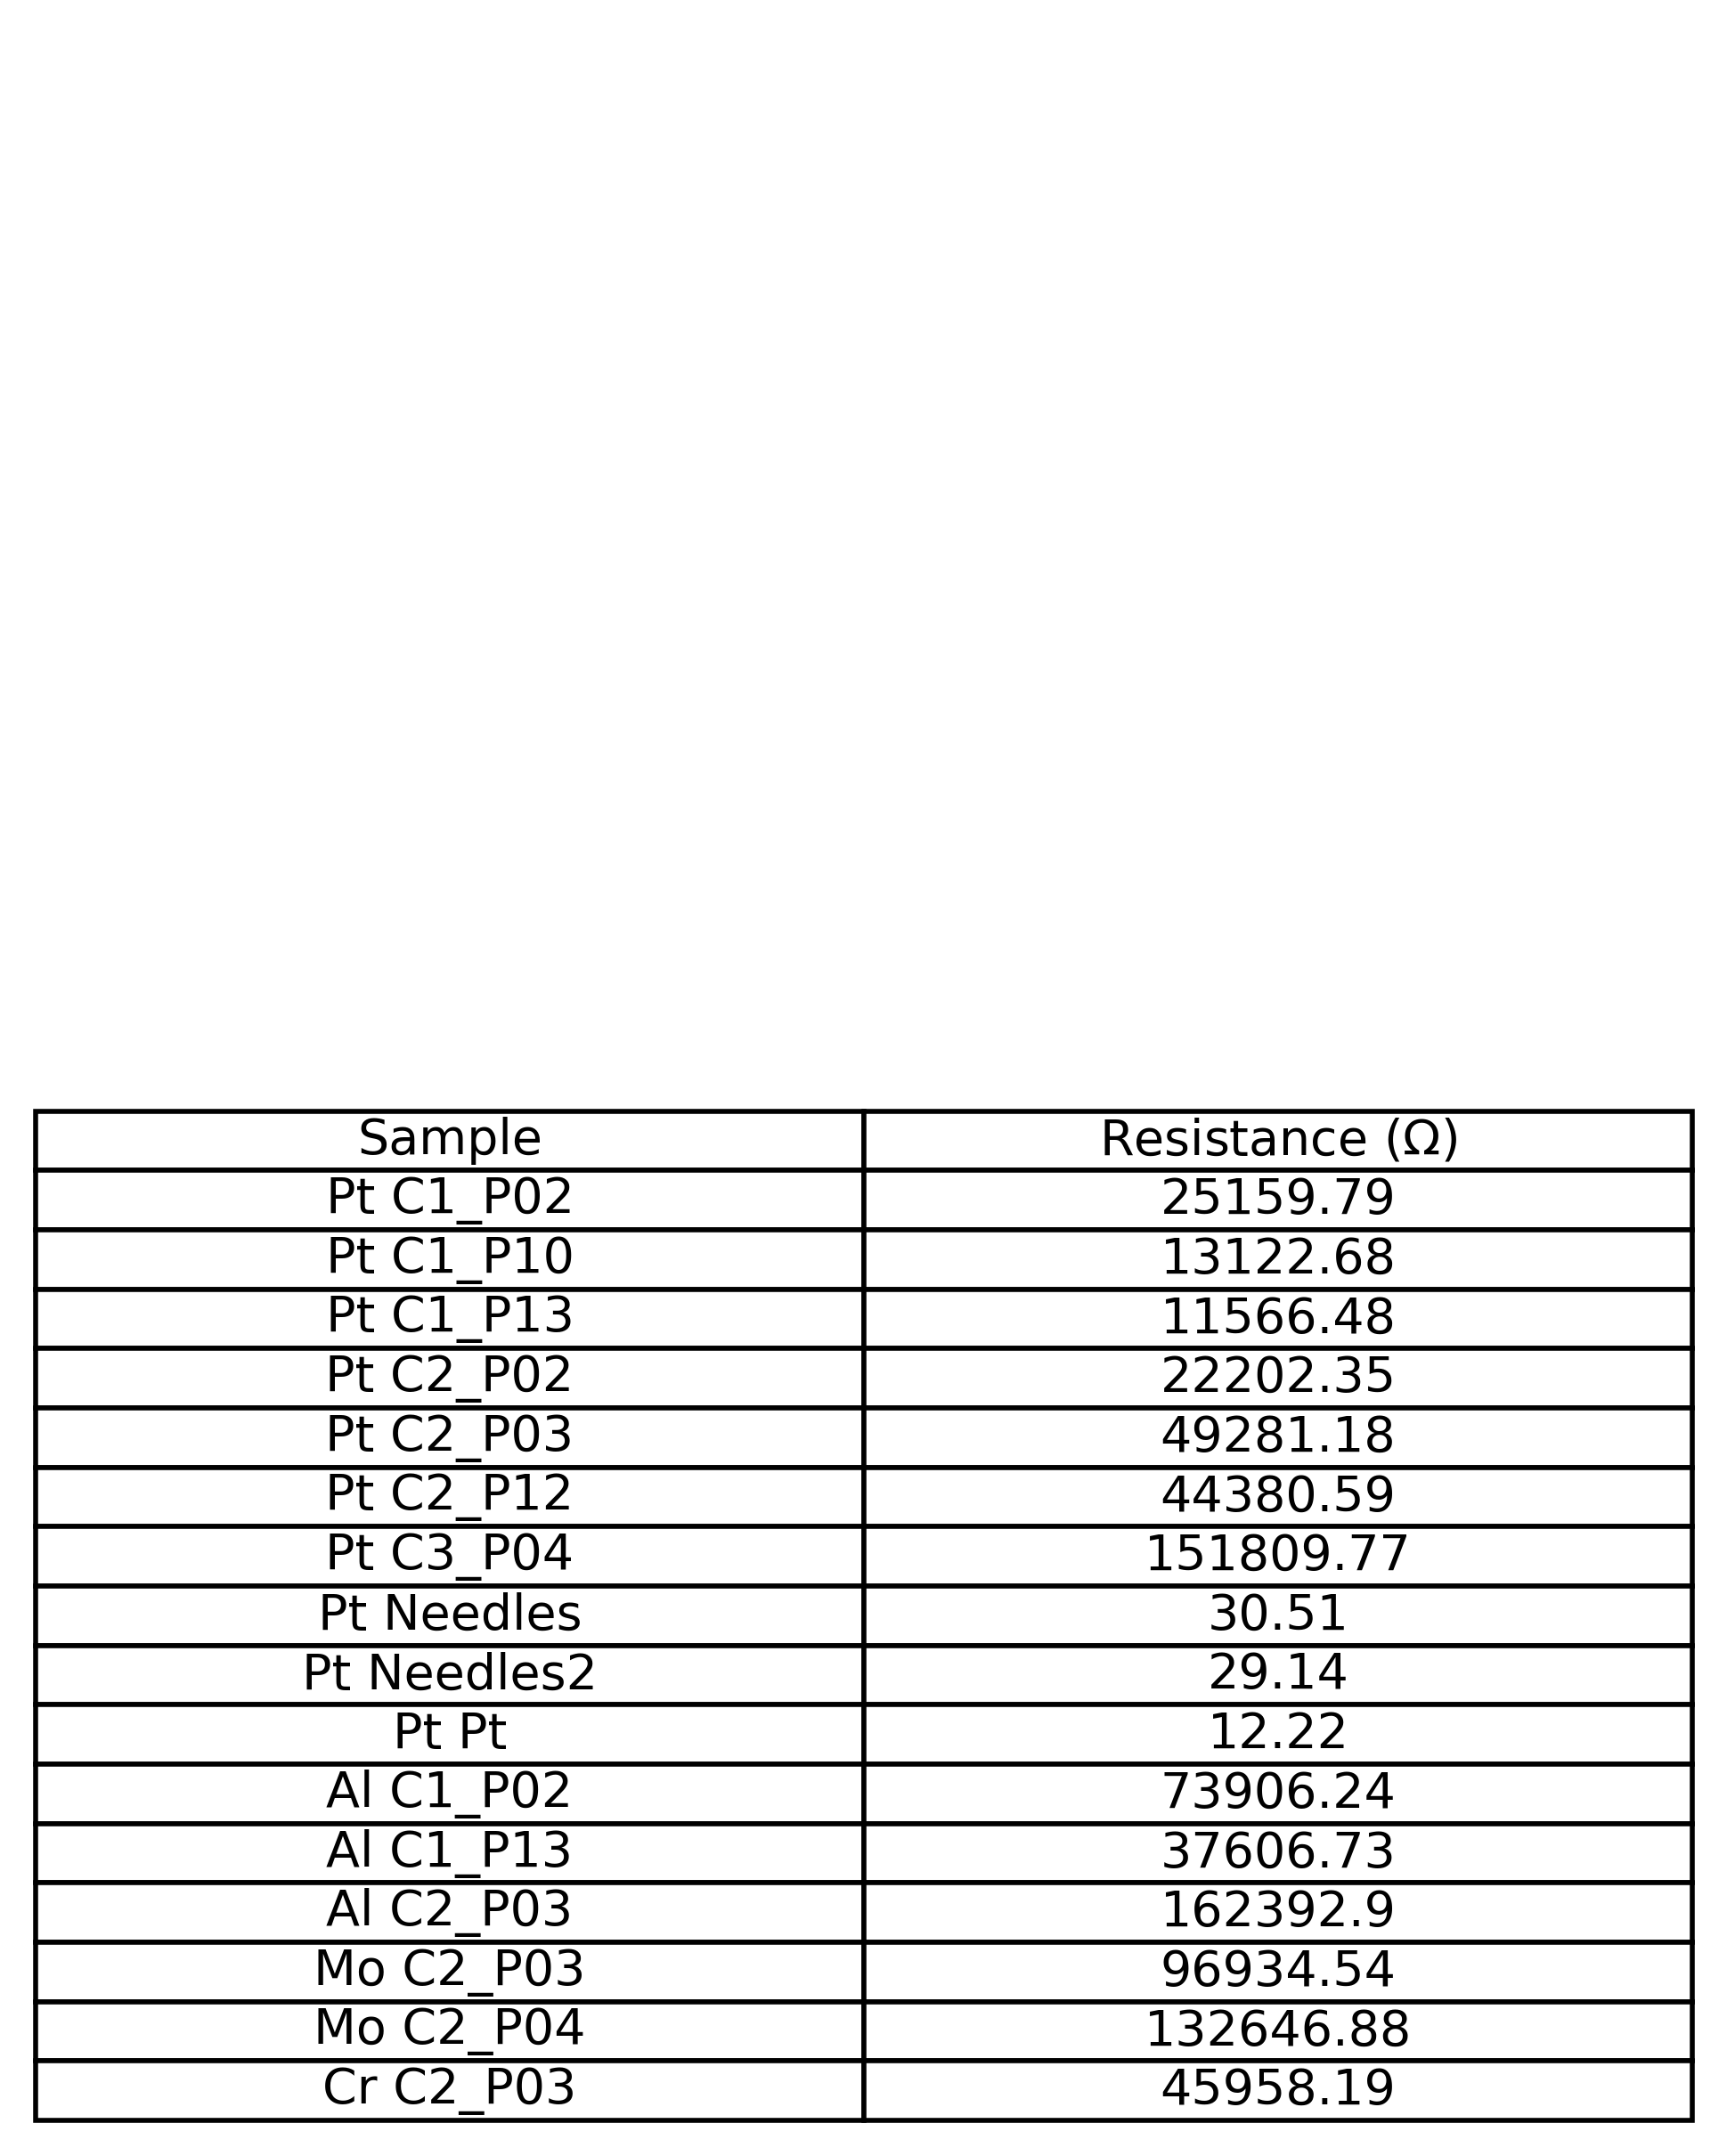

In [24]:

# Resistance table
resistance_table = pd.DataFrame(list(r_dict.items()), columns = ['Sample', 'Resistance (Ω)'])#, index = row_names)
fig, ax = plt.subplots(dpi = 400)
ax.axis('off')
t = ax.table(cellText=resistance_table.values, cellLoc='center', colLabels= ['Sample', 'Resistance ($\Omega$)'])

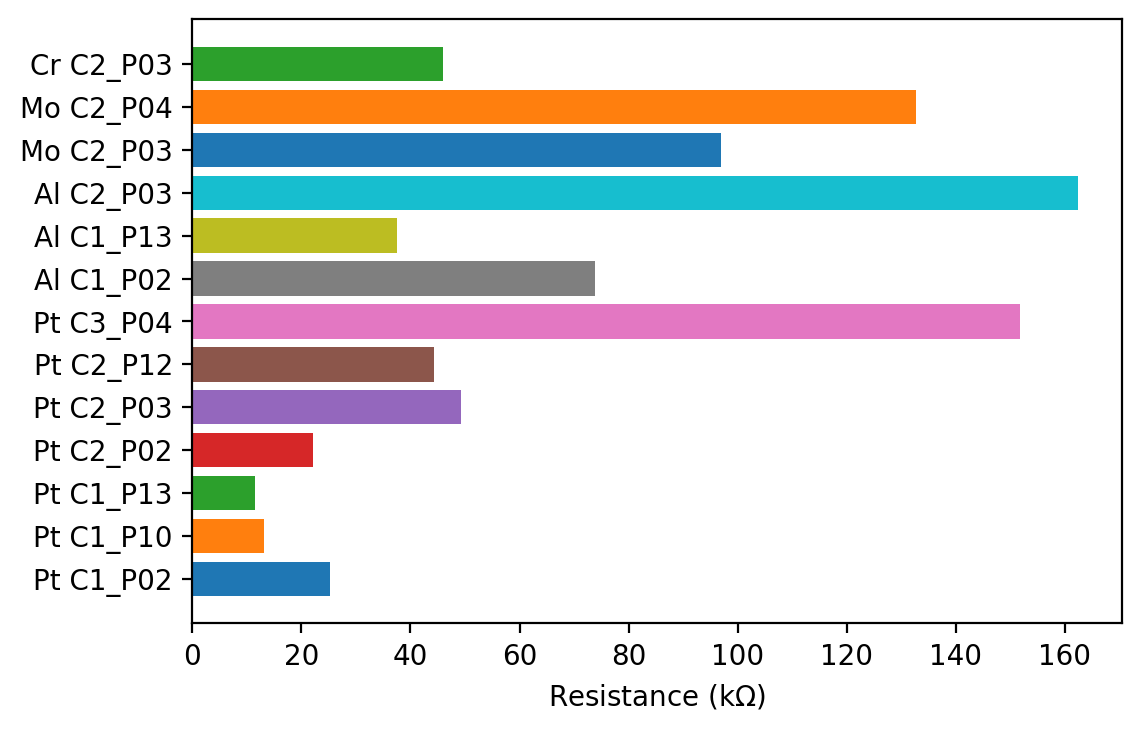

In [23]:
# Bar plot resistance
fig, ax = plt.subplots(dpi = 200, facecolor = 'white')
ax.set_xlabel('Resistance (k$\Omega$)')
for i in resistance_table.values:
    if i[1] > 100:
        ax.barh(i[0], i[1] / 1000)
        #if 'P04' in i[0]:
        #    ax.bar(i[0], i[1])
    #plt.xticks(rotation='vertical')